<a href="https://colab.research.google.com/github/yum-cloud-94/CAPTCHA-BREAK-AI/blob/CRNN_Modeling/Vanilla_CAPTCHA_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("Tensorflow version: ", tf.__version__)

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

Tensorflow version:  2.2.0


# Read Data

Number of images found:  10000
Shape of image:  (50, 150, 3)
Shape of image:  (50, 150, 3)
Shape of image:  (50, 150, 3)
Shape of image:  (50, 150, 3)


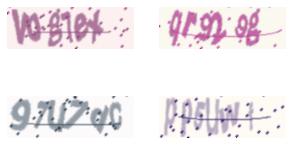

In [ ]:
dir = "/content/drive/My Drive/KPMG/CAPTCHA-BREAK-AI/captcha/"
os.chdir(dir)
# data_dir = Path("/content/drive/My Drive/KPMG/CAPTCHA-BREAK-AI/data/")

# Get list of all the images
# images = list(data_dir.glob("*.png"))
images = os.listdir(dir)
# images = images[:2000]
print("Number of images found: ", len(images))


# Let's take a look at some samples first. 
# Always look at your data!

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(images[i])
    # img = cv2.imread(images[i])
    # plt.imshow(img)
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

In [ ]:
# Store all the characters in a set
characters = set()

# A list to store the length of each captcha
captcha_length = []

# Store image-label info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.split(".")[0]
    if len(label)!=6:
      continue
    # 2. Store the length of this cpatcha
    captcha_length.append(len(label))
    # 3. Store the image-label pair info
    dataset.append((str(img_path), label))
    
    # 4. Store the characters present
    for ch in label:
        characters.add(ch)

# Sort the characters        
characters = sorted(characters)

# Convert the dataset info into a dataframe
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)


print("Number of unqiue charcaters in the whole dataset: ", len(characters))
print("Maximum length of any captcha: ", max(Counter(captcha_length).keys()))
print("Characters present: ", characters)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head()

Number of unqiue charcaters in the whole dataset:  36
Maximum length of any captcha:  6
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total number of samples in the dataset:  10000


,img_path,label
0,usfq98.png,usfq98
1,xvl0bn.png,xvl0bn
2,s7d4cl.png,s7d4cl
3,3tgfk6.png,3tgfk6
4,cd3cri.png,cd3cri


# Data Preprocessing

In [ ]:
# Split the dataset into training and validation sets
training_data, validation_data = train_test_split(dataset, test_size=0.2, random_state=seed)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))


# Map text to numeric labels 
char_to_labels = {char:idx for idx, char in enumerate(characters)}

# Map numeric labels to text
labels_to_char = {val:key for key, val in char_to_labels.items()}


# Sanity check for corrupted images
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True

# Store arrays in memory as it's not a muvh big dataset
def generate_arrays(df, resize=True, img_height=50, img_width=150):
    """Generates image array and labels array from a dataframe.
    
    Args:
        df: dataframe from which we want to read the data
        resize (bool)    : whether to resize images or not
        img_weidth (int): width of the resized images
        img_height (int): height of the resized images
        
    Returns:
        images (ndarray): grayscale images
        labels (ndarray): corresponding encoded labels
    """
    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # Add only if it is a valid captcha
        if is_valid_captcha(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)

# Build training data
training_data, training_labels = generate_arrays(df=training_data)
print("Number of training images: ", training_data.shape)
print("Number of training labels: ", training_labels.shape)


# Build validation data
validation_data, validation_labels = generate_arrays(df=validation_data)
print("Number of validation images: ", validation_data.shape)
print("Number of validation labels: ", validation_labels.shape)

Number of training samples:  8000
Number of validation samples:  2000
Number of training images:  (8000, 50, 150)
Number of training labels:  (8000,)
Number of validation images:  (2000, 50, 150)
Number of validation labels:  (2000,)


In [ ]:
class DataGenerator(keras.utils.Sequence):
    """Generates batches from a given dataset.
    
    Args:
        data: training or validation data
        labels: corresponding labels
        char_map: dictionary mapping char to labels
        batch_size: size of a single batch
        img_width: width of the resized
        img_height: height of the resized
        downsample_factor: by what factor did the CNN downsample the images
        max_length: maximum length of any captcha
        shuffle: whether to shuffle data or not after each epoch
    Returns:
        batch_inputs: a dictionary containing batch inputs 
        batch_labels: a batch of corresponding labels 
    """
    
    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=150,
                 img_height=50,
                 downsample_factor=8,
                 max_length=6,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Get the next batch indices
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # 2. This isn't necessary but it can help us save some memory
        # as not all batches the last batch may not have elements
        # equal to the batch_size 
        batch_len = len(curr_batch_idx)
        
        # 3. Instantiate batch arrays
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        
        for j, idx in enumerate(curr_batch_idx):
            # 1. Get the image and transpose it
            img = self.data[idx].T
            # 2. Add extra dimenison
            img = np.expand_dims(img, axis=-1)
            # 3. Get the correpsonding label
            text = self.labels[idx]
            # 4. Include the pair only if the captcha is valid
            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)
        
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width=150
img_height=50 

# Factor  by which the image is going to be downsampled
# by the convolutional blocks
downsample_factor=8

# Maximum length of any captcha in the data
max_length=6

# Get a generator object for the training data
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

# Get a generator object for the validation data 
valid_data_generator = DataGenerator(data=validation_data,
                                     labels=validation_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

# Make model and fitting

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # On test time, just return the computed loss
        return loss



def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
    # First conv block

    x = layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)

    x = layers.Conv2D(128,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)
    
    # Second conv block
    x = layers.Conv2D(256,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv3')(x)
    x = layers.MaxPooling2D((2,2), name='pool3')(x)
    
    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((img_width // 8), (img_height // 8)*256)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(256, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(512,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(256,
                                         return_sequences=True,
                                         dropout=0.25))(x)
    
    # Predictions
    x = layers.Dense(len(characters)+1,
              activation='softmax', 
              name='dense2',
              kernel_initializer='he_normal')(x)
    
    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Define the model
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    
    # Optimizer
    sgd = keras.optimizers.SGD(learning_rate=0.005,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    
    # Compile the model and return 
    model.compile(optimizer=sgd, metrics=['accuracy'])
    return model

<tf.Tensor 'input_length_1:0' shape=(None, 1) dtype=int64>

In [ ]:
model = build_model()
# model.summary()

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=200,
                                   restore_best_weights=True)

# Train the model
history = model.fit(train_data_generator,
                    validation_data=valid_data_generator,
                    epochs=250,
                    callbacks=[es])

Epoch 1/250
500/500 [==============================] - 24s 47ms/step - loss: 22.9948 - accuracy: 0.0000e+00 - val_loss: 22.8210 - val_accuracy: 0.0000e+00
Epoch 2/250
500/500 [==============================] - 22s 44ms/step - loss: 22.7213 - accuracy: 0.0000e+00 - val_loss: 22.7516 - val_accuracy: 0.0000e+00
Epoch 3/250
500/500 [==============================] - 23s 45ms/step - loss: 22.6606 - accuracy: 0.0000e+00 - val_loss: 22.4858 - val_accuracy: 0.0000e+00
Epoch 4/250
500/500 [==============================] - 23s 45ms/step - loss: 22.5216 - accuracy: 0.0000e+00 - val_loss: 22.3734 - val_accuracy: 0.0000e+00
Epoch 5/250
500/500 [==============================] - 22s 45ms/step - loss: 22.4061 - accuracy: 0.0000e+00 - val_loss: 22.3274 - val_accuracy: 0.0000e+00
Epoch 6/250
500/500 [==============================] - 23s 45ms/step - loss: 22.3452 - accuracy: 0.0000e+00 - val_loss: 22.3408 - val_accuracy: 0.0000e+00
Epoch 7/250
500/500 [==============================] - 22s 45ms/step -

In [ ]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      [(None, 150, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 150, 50, 64)       640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 75, 25, 64)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 75, 25, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 37, 12, 128)       0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 37, 12, 256)       295168    
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 18, 6, 256)        0   

# Prediction Decode

In [ ]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    
    # return final text results
    return output_text

In [ ]:
#  Let's check results on some validation samples
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    print(X_data.shape)
    labels = inp_value['input_label']
    print(labels.shape)

    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

(16, 150, 50, 1)
(16, 6)
Ground truth: 7t41zr 	 Predicted: 7t41zr
Ground truth: bkovqu 	 Predicted: bkovqu
Ground truth: t4a3t8 	 Predicted: t4a3t8
Ground truth: x1jv6a 	 Predicted: x1sv6a
Ground truth: ku7jov 	 Predicted: ku7jov
Ground truth: wp8h3j 	 Predicted: wp8h3j
Ground truth: rlnoxq 	 Predicted: rlnoxq
Ground truth: 0s48tm 	 Predicted: 0s48tm
Ground truth: 4yc6fu 	 Predicted: 4yc6fu
Ground truth: spfj96 	 Predicted: spfj96
Ground truth: fnuh4b 	 Predicted: fnuh4b
Ground truth: a9ody1 	 Predicted: a9ody1
Ground truth: 07w96p 	 Predicted: 07w96p
Ground truth: ooequ6 	 Predicted: ooequ6
Ground truth: 9hhqaa 	 Predicted: 9hhqaa
Ground truth: 9mh0br 	 Predicted: 9mh0br


In [ ]:
size=len(validation_labels)
curr_idx=np.arange(size)

X = np.ones((size, 150, 50, 1),dtype=np.float32)
Y = np.ones((size, 6), dtype=np.float32)
# input_length = np.ones((batch_len, 1), dtype=np.int64) * \
#                         (self.img_width // self.downsample_factor - 2)
# label_length = np.zeros((batch_len, 1), dtype=np.int64)

for j, idx in enumerate(curr_idx):
  # 1. Get the image and transpose it
  img = validation_data[idx].T
  # 2. Add extra dimenison
  img = np.expand_dims(img, axis=-1)
  # 3. Get the correpsonding label
  text = validation_labels[idx]
  # 4. Include the pair only if the captcha is valid
  if is_valid_captcha(text):
    label = [char_to_labels[ch] for ch in text]
    X[j] = img
    Y[j] = label


In [ ]:
def my_eval(x,y,model):

  preds=model.predict(x)
  pred_texts=decode_batch_predictions(preds)
  cnt=0
  orig_texts = []
  for label in y:
      text = ''.join([labels_to_char[int(x)] for x in label])
      orig_texts.append(text)
  
  for i in range(len(y)):
    if pred_texts[i]==orig_texts[i]:
      cnt=cnt+1
  print(cnt)
  return cnt/len(pred_texts)


# Test Data Evaluate

Number of images found:  2000
Shape of image:  (50, 150, 3)
Shape of image:  (50, 150, 3)
Shape of image:  (50, 150, 3)
Shape of image:  (50, 150, 3)


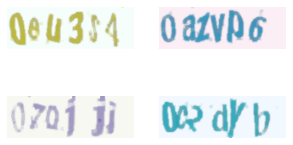

In [ ]:
dir = "/content/drive/My Drive/KPMG/CAPTCHA-BREAK-AI/testcaptcha/"
os.chdir(dir)
# data_dir = Path("/content/drive/My Drive/KPMG/CAPTCHA-BREAK-AI/data/")

# Get list of all the images
# images = list(data_dir.glob("*.png"))
images = os.listdir(dir)
print("Number of images found: ", len(images))

# Let's take a look at some samples first. 
# Always look at your data!

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(images[i])
    # img = cv2.imread(images[i])
    # plt.imshow(img)
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

In [ ]:
# Store all the characters in a set
characters = set()

# A list to store the length of each captcha
captcha_length = []

# Store image-label info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.split(".")[0]
    if len(label)!=6:
      continue

    # 2. Store the length of this cpatcha
    captcha_length.append(len(label))
    # 3. Store the image-label pair info
    dataset.append((str(img_path), label))
    
    # 4. Store the characters present
    for ch in label:
        characters.add(ch)

# Sort the characters        
characters = sorted(characters)

# Convert the dataset info into a dataframe
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)
test_data= dataset.copy()

print("Number of unqiue charcaters in the whole dataset: ", len(characters))
print("Maximum length of any captcha: ", max(Counter(captcha_length).keys()))
print("Characters present: ", characters)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head()

Number of unqiue charcaters in the whole dataset:  36
Maximum length of any captcha:  6
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total number of samples in the dataset:  2000


,img_path,label
0,k4hp5c.png,k4hp5c
1,j5uusm.png,j5uusm
2,cz87rl.png,cz87rl
3,ymc56i.png,ymc56i
4,n0hlv2.png,n0hlv2


In [ ]:
# Map text to numeric labels 
char_to_labels = {char:idx for idx, char in enumerate(characters)}

# Map numeric labels to text
labels_to_char = {val:key for key, val in char_to_labels.items()}

# Sanity check for corrupted images
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True

# Store arrays in memory as it's not a muvh big dataset
def generate_arrays(df, resize=True, img_height=img.shape[0], img_width=img.shape[1]):
    """Generates image array and labels array from a dataframe.
    
    Args:
        df: dataframe from which we want to read the data
        resize (bool)    : whether to resize images or not
        img_weidth (int): width of the resized images
        img_height (int): height of the resized images
        
    Returns:
        images (ndarray): grayscale images
        labels (ndarray): corresponding encoded labels
    """
    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # Add only if it is a valid captcha
        if is_valid_captcha(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)

# Build training data
test_data, test_labels = generate_arrays(df=test_data)
print("Number of test images: ", test_data.shape)
print("Number of test labels: ", test_labels.shape)


Number of test images:  (2000, 50, 150)
Number of test labels:  (2000,)


In [ ]:
class DataGenerator(keras.utils.Sequence):
    """Generates batches from a given dataset.
    
    Args:
        data: training or validation data
        labels: corresponding labels
        char_map: dictionary mapping char to labels
        batch_size: size of a single batch
        img_width: width of the resized
        img_height: height of the resized
        downsample_factor: by what factor did the CNN downsample the images
        max_length: maximum length of any captcha
        shuffle: whether to shuffle data or not after each epoch
    Returns:
        batch_inputs: a dictionary containing batch inputs 
        batch_labels: a batch of corresponding labels 
    """
    
    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size,
                 img_width,
                 img_height,
                 downsample_factor,
                 max_length,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Get the next batch indices
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # 2. This isn't necessary but it can help us save some memory
        # as not all batches the last batch may not have elements
        # equal to the batch_size 
        batch_len = len(curr_batch_idx)
        
        # 3. Instantiate batch arrays
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        
        for j, idx in enumerate(curr_batch_idx):
            # 1. Get the image and transpose it
            img = self.data[idx].T
            # 2. Add extra dimenison
            img = np.expand_dims(img, axis=-1)
            # 3. Get the correpsonding label
            text = self.labels[idx]
            # 4. Include the pair only if the captcha is valid
            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)
        
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width=img.shape[1]
img_height=img.shape[0]

# Factor  by which the image is going to be downsampled
# by the convolutional blocks
downsample_factor=8

# Maximum length of any captcha in the data
max_length=6

# Get a generator object for the training data
test_data_generator = DataGenerator(data=test_data,
                                     labels=test_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )



In [ ]:
size=len(test_labels)
curr_idx=np.arange(size)

X = np.ones((size, 150, 50, 1),dtype=np.float32)
Y = np.ones((size, 6), dtype=np.float32)
# input_length = np.ones((batch_len, 1), dtype=np.int64) * \
#                         (self.img_width // self.downsample_factor - 2)
# label_length = np.zeros((batch_len, 1), dtype=np.int64)

for j, idx in enumerate(curr_idx):
  # 1. Get the image and transpose it
  img = test_data[idx].T
  # 2. Add extra dimenison
  img = np.expand_dims(img, axis=-1)
  # 3. Get the correpsonding label
  text = test_labels[idx]
  # 4. Include the pair only if the captcha is valid
  if is_valid_captcha(text):
    label = [char_to_labels[ch] for ch in text]
    X[j] = img
    Y[j] = label


In [ ]:
def my_eval(x,y,model):
  preds=model.predict(x)
  pred_texts=decode_batch_predictions(preds)
  cnt=0
  orig_texts = []
  for label in y:
      text = ''.join([labels_to_char[int(x)] for x in label])
      orig_texts.append(text)
  
  for i in range(len(y)):
    if pred_texts[i]==orig_texts[i]:
      cnt=cnt+1
  return cnt/len(pred_texts)


In [ ]:
acc=my_eval(X,Y,prediction_model)
print(acc)

1655
0.8275


In [ ]:
# 모델저장
from keras.models import model_from_json
model_json = model.to_json()
with open("/content/drive/My Drive/KPMG/CAPTCHA-BREAK-AI/model/captcha_model.json", "w") as json_file:
  json_file.write(model_json)

# 가중치 저장
model.save_weights("/content/drive/My Drive/KPMG/CAPTCHA-BREAK-AI/model/captcha_weight.h5")

# Prediction 모델저장
from keras.models import model_from_json
prediction_model_json = prediction_model.to_json()
with open("/content/drive/My Drive/KPMG/CAPTCHA-BREAK-AI/model/captcha_prediction_model.json", "w") as json_file:
  json_file.write(prediction_model_json)

# Prediction 가중치 저장
prediction_model.save_weights("/content/drive/My Drive/KPMG/CAPTCHA-BREAK-AI/model/captcha_prediction_weight.h5")


Using TensorFlow backend.


In [ ]:
from tensorflow.compat.v2.keras.models import model_from_json

# 모델, weight 로드
json_file = open("/content/drive/My Drive/KPMG/CAPTCHA-BREAK-AI/model/newcaptcha_prediction_model.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
# weight = '/content/drive/My Drive/KPMG/CAPTCHA-BREAK=AI/model/newcaptcha_prediction_model.h5'
# loaded_model.load_weights(weight)

In [ ]:
# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/CAPTCHA-BREAK-AI/model/captcha_prediction_weight.h5'
loaded_model.load_weights(weight)